# This is just a playground for me 

In [1]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1;
    X_locations = np.array(X_locations)
    Y_locations = np.array(Y_locations)
    Z_locations = np.array(Z_locations) 
    
    X_locs_1, X_locs_2 = X_locations[:21], X_locations[21:]
    Y_locs_1, Y_locs_2 = Y_locations[:21], Y_locations[21:]
    Z_locs_1, Z_locs_2 = Z_locations[:21], Z_locations[21:]
    locations = np.array([locs[np.nonzero(locs)].mean() for locs in [X_locs_1, X_locs_2, Y_locs_1, Y_locs_2, Z_locs_1, Z_locs_2] ])
    hands.close()
    return np.nan_to_num(locations)


def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 3))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations) 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [6]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('mean_point_folds'): 
    with open(f"mean_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)
X = np.nan_to_num(X)

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [28]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 2


In [23]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 6)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6840 - accuracy: 0.5375 - precision_21: 0.5385 - recall_21: 0.8333 - val_loss: 0.7075 - val_accuracy: 0.4000 - val_precision_21: 0.4000 - val_recall_21: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6540 - accuracy: 0.5875 - precision_21: 0.5600 - recall_21: 1.0000 - val_loss: 0.6727 - val_accuracy: 0.6000 - val_precision_21: 0.5000 - val_recall_21: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6558 - accuracy: 0.6875 - precision_21: 0.6809 - recall_21: 0.7619 - val_loss: 0.6934 - val_accuracy: 0.6000 - val_precision_21: 0.5000 - val_recall_21: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6189 - accuracy: 0.6625 - precision_21: 0.6829 - recall_21: 0.6667 - val_loss: 0.6502 - val_accuracy: 0.6500 - val_precision_21: 0.5455 - val_recall_21: 0.7500
Epoch 5/75
3/3 [==============================] - 0s 145ms/step 

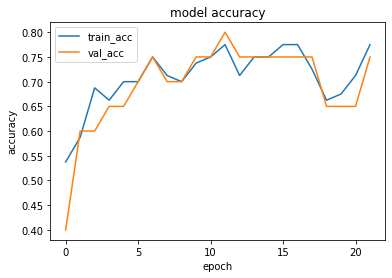

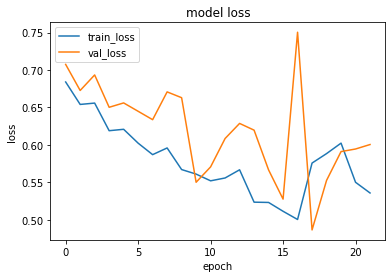

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.5981662]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.61350894]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.65849125]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.51497704]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.4736087]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.4485249]]
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.7093 - accuracy: 0.3750 - precision_22: 0.4355 - recall_22: 0.6429 - val_loss: 0.7085 - val_accuracy: 0.4000 - val_precision_22: 0.4000 - val_recall_22: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6832 - accuracy: 0.5375 - precision_22: 0.5362 - recall_22: 0.8810 - val_loss: 0.6821 - val_accuracy: 0.5000 - val_precision_22: 0.3750 - val_recall_22: 0.3750
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6734 - accuracy: 0.7250 - precision_22: 0.7273 - recall_22: 0.7619 - val_loss: 0.6848 - val_accuracy: 0.6000 - val_precision_22: 0.5000 - val_recall_22: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6572 - accuracy: 0.5875 - precision_22: 0.5672 - recall_22: 0.9048 - val_loss: 0.6640 - val_accuracy: 0.5000 - val_precision_22: 0.4167 - val_recall_22: 0.6250
Epoch 5/75
3

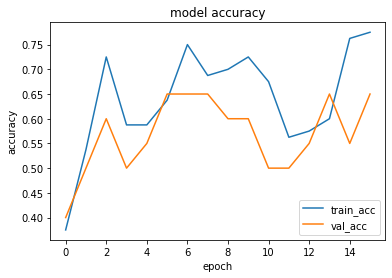

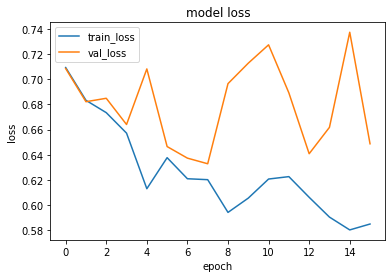

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5281568]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.5678227]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.5662633]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.47452766]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.45334536]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.44042087]]
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6830 - accuracy: 0.6000 - precision_23: 0.5714 - recall_23: 0.5405 - val_loss: 0.7087 - val_accuracy: 0.4000 - val_precision_23: 1.0000 - val_recall_23: 0.0769
Epoch 2/75
3/3 [==============================] - 0s 193ms/step - loss: 0.6617 - accuracy: 0.5375 - precision_23: 0.5000 - recall_23: 0.1081 - val_loss: 0.6891 - val_accuracy: 0.5500 - val_precision_23: 1.0000 - val_recall_23: 0.3077
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6184 - accuracy: 0.6625 - precision_23: 0.7083 - recall_23: 0.4595 - val_loss: 0.6012 - val_accuracy: 0.8000 - val_precision_23: 0.9091 - val_recall_23: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6026 - accuracy: 0.6875 - precision_23: 0.6364 - recall_23: 0.7568 - val_loss: 0.5979 - val_accuracy: 0.8500 - val_precision_23: 1.0000 - val_recall_23: 0.7692
Epoch 5/75


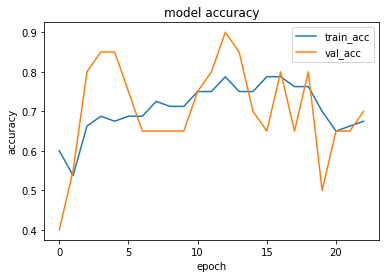

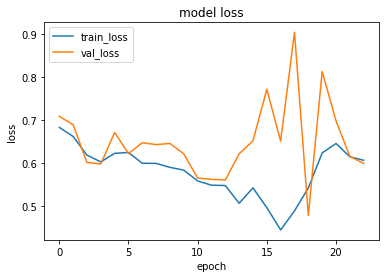

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.3987146]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.47588313]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.49697673]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.32431275]]


1it [00:00, 18641.35it/s]


prediction for video control_2.mov is [[0.30738765]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.29051]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6858 - accuracy: 0.4750 - precision_24: 0.4000 - recall_24: 0.1000 - val_loss: 0.6819 - val_accuracy: 0.6500 - val_precision_24: 0.6667 - val_recall_24: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6622 - accuracy: 0.5500 - precision_24: 0.5357 - recall_24: 0.7500 - val_loss: 0.6675 - val_accuracy: 0.5000 - val_precision_24: 0.5000 - val_recall_24: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6163 - accuracy: 0.6250 - precision_24: 0.5781 - recall_24: 0.9250 - val_loss: 0.5854 - val_accuracy: 0.6500 - val_precision_24: 0.6000 - val_recall_24: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6850 - accuracy: 0.6625 - precision_24: 0.6327 - recall_24: 0.7750 - val_loss: 0.6505 - val_accuracy: 0.5000 - val_precision_24: 0.5000 - val_recall_24: 1.0000
Epoch 5/75
3/3

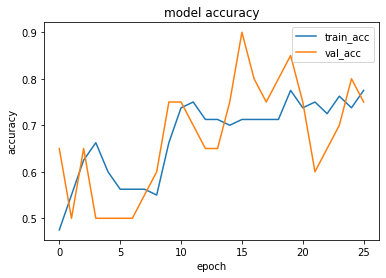

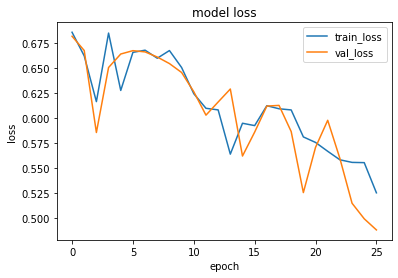

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.6278707]]


1it [00:00, 11214.72it/s]


prediction for video armflapping_3.mov is [[0.7124944]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.7472549]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.4366797]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.3754055]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.341686]]
Epoch 1/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6981 - accuracy: 0.4500 - precision_25: 0.4138 - recall_25: 0.3077 - val_loss: 0.6846 - val_accuracy: 0.4500 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6806 - accuracy: 0.6250 - precision_25: 0.7143 - recall_25: 0.3846 - val_loss: 0.6496 - val_accuracy: 0.7000 - val_precision_25: 0.8571 - val_recall_25: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6634 - accuracy: 0.7500 - precision_25: 0.7568 - recall_25: 0.7179 - val_loss: 0.6249 - val_accuracy: 0.7000 - val_precision_25: 0.8571 - val_recall_25: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 190ms/step - loss: 0.6372 - accuracy: 0.7375 - precision_25: 0.6957 - recall_25: 0.8205 - val_loss: 0.5784 - val_accuracy: 0.7500 - val_precision_25: 0.7500 - val_recall_25: 0.8182
Epoch

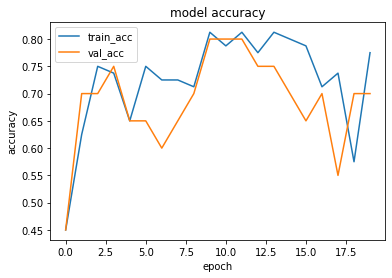

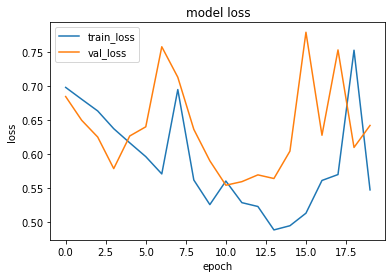

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.25691453]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.4605536]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.52589095]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.21582806]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.20691499]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.20558023]]


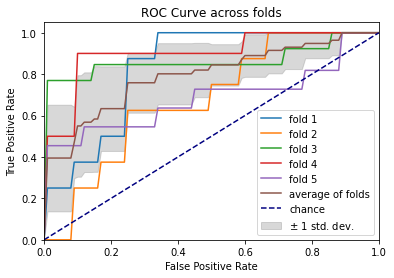

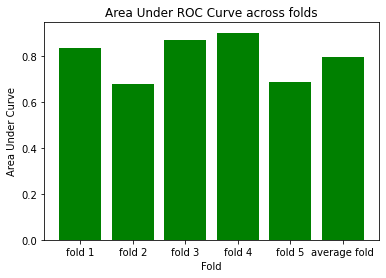

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6971 - accuracy: 0.4750 - precision_27: 0.5000 - recall_27: 0.5952 - val_loss: 0.6918 - val_accuracy: 0.4500 - val_precision_27: 0.4211 - val_recall_27: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 194ms/step - loss: 0.6823 - accuracy: 0.5500 - precision_27: 0.5417 - recall_27: 0.9286 - val_loss: 0.6825 - val_accuracy: 0.4500 - val_precision_27: 0.4211 - val_recall_27: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6716 - accuracy: 0.6000 - precision_27: 0.5962 - recall_27: 0.7381 - val_loss: 0.6581 - val_accuracy: 0.8000 - val_precision_27: 0.7000 - val_recall_27: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6449 - accuracy: 0.7000 - precision_27: 0.7500 - recall_27: 0.6429 - val_loss: 0.6945 - val_accuracy: 0.5500 - val_precision_27: 0.4706 - val_recall_27: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 131ms/step 

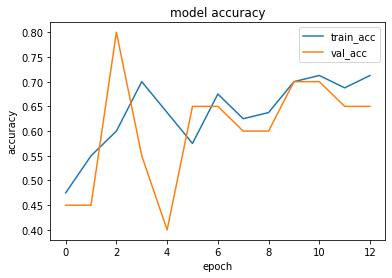

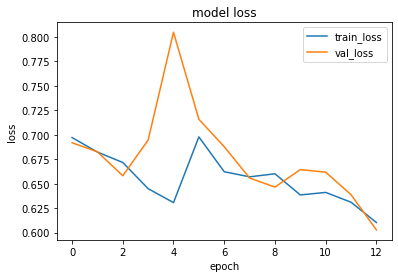

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5016121]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4969018]]


1it [00:00, 12300.01it/s]


prediction for video armflapping_2.mov is [[0.5104222]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.49575272]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.49313375]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.4926833]]
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6970 - accuracy: 0.4750 - precision_28: 0.5000 - recall_28: 0.5952 - val_loss: 0.7039 - val_accuracy: 0.4000 - val_precision_28: 0.4000 - val_recall_28: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6859 - accuracy: 0.5250 - precision_28: 0.5250 - recall_28: 1.0000 - val_loss: 0.7214 - val_accuracy: 0.4000 - val_precision_28: 0.4000 - val_recall_28: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6683 - accuracy: 0.5375 - precision_28: 0.5316 - recall_28: 1.0000 - val_loss: 0.6976 - val_accuracy: 0.4500 - val_precision_28: 0.4211 - val_recall_28: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6463 - accuracy: 0.6625 - precision_28: 0.6190 - recall_28: 0.9286 - val_loss: 0.6699 - val_accuracy: 0.6000 - val_precision_28: 0.5000 - val_recall_28: 0.6250
Epoch 5/75
3

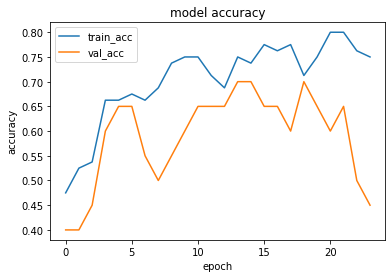

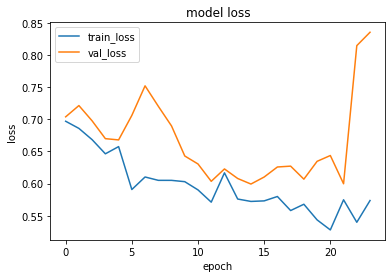

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.43955606]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.73626286]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.7379013]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.31459367]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.26273865]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.2572535]]
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6940 - accuracy: 0.4750 - precision_29: 0.3529 - recall_29: 0.1622 - val_loss: 0.7299 - val_accuracy: 0.3500 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6666 - accuracy: 0.6125 - precision_29: 1.0000 - recall_29: 0.1622 - val_loss: 0.6951 - val_accuracy: 0.6500 - val_precision_29: 0.6667 - val_recall_29: 0.9231
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6473 - accuracy: 0.4875 - precision_29: 0.4615 - recall_29: 0.6486 - val_loss: 0.7310 - val_accuracy: 0.6000 - val_precision_29: 0.6667 - val_recall_29: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.8161 - accuracy: 0.4625 - precision_29: 0.4118 - recall_29: 0.3784 - val_loss: 0.8284 - val_accuracy: 0.5000 - val_precision_29: 0.6667 - val_recall_29: 0.4615
Epoc

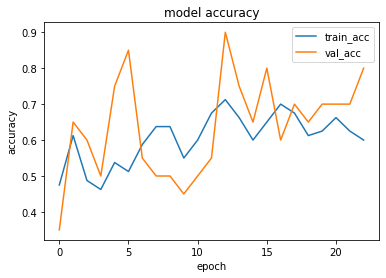

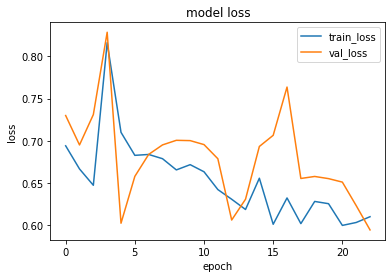

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.40743375]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.48550916]]


1it [00:00, 17050.02it/s]


prediction for video armflapping_2.mov is [[0.5038142]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.32380664]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.29951313]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.35081032]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.7019 - accuracy: 0.5125 - precision_30: 0.5122 - recall_30: 0.5250 - val_loss: 0.6836 - val_accuracy: 0.5000 - val_precision_30: 0.5000 - val_recall_30: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6666 - accuracy: 0.6125 - precision_30: 0.5818 - recall_30: 0.8000 - val_loss: 0.6831 - val_accuracy: 0.5500 - val_precision_30: 0.5714 - val_recall_30: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6569 - accuracy: 0.5750 - precision_30: 0.5714 - recall_30: 0.6000 - val_loss: 0.6716 - val_accuracy: 0.5500 - val_precision_30: 0.5263 - val_recall_30: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6232 - accuracy: 0.6125 - precision_30: 0.5692 - recall_30: 0.9250 - val_loss: 0.6589 - val_accuracy: 0.5500 - val_precision_30: 0.5263 - val_recall_30: 1.0000
Epoch 5/75


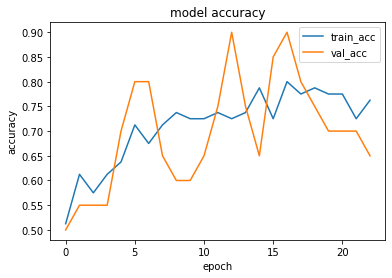

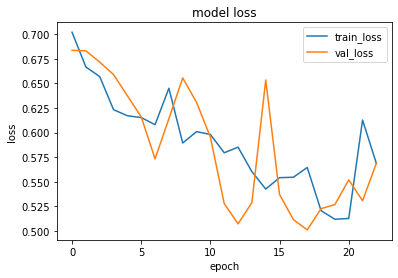

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.519306]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.54285395]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_2.mov is [[0.5989345]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.4406235]]


1it [00:00, 17772.47it/s]


prediction for video control_2.mov is [[0.40955535]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.38310218]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.7035 - accuracy: 0.4250 - precision_31: 0.1818 - recall_31: 0.0513 - val_loss: 0.6852 - val_accuracy: 0.3500 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6899 - accuracy: 0.5875 - precision_31: 0.5789 - recall_31: 0.5641 - val_loss: 0.6684 - val_accuracy: 0.6500 - val_precision_31: 0.6111 - val_recall_31: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6810 - accuracy: 0.5500 - precision_31: 0.5217 - recall_31: 0.9231 - val_loss: 0.6352 - val_accuracy: 0.7000 - val_precision_31: 0.6667 - val_recall_31: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6526 - accuracy: 0.6000 - precision_31: 0.5574 - recall_31: 0.8718 - val_loss: 0.6244 - val_accuracy: 0.7000 - val_precision_31: 0.7778 - val_recall_31: 0.6364
Epo

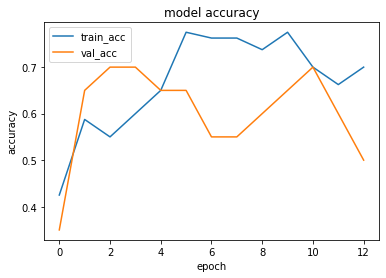

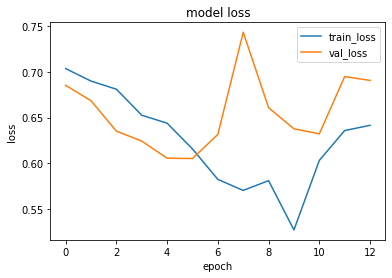

1it [00:00, 16644.06it/s]


prediction for video armflapping_1.mov is [[0.55489796]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5925596]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.618271]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.3378388]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.28818178]]


1it [00:00, 19152.07it/s]


prediction for video control_3.mov is [[0.28292695]]


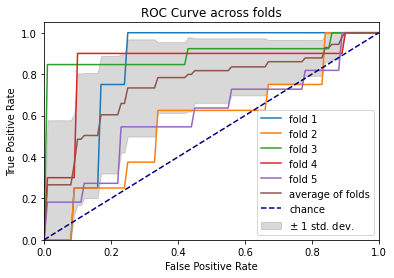

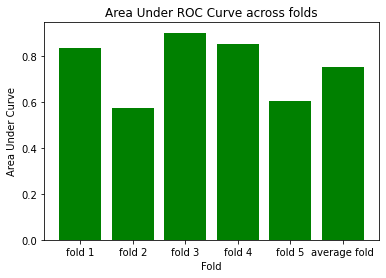

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.6807 - accuracy: 0.5625 - precision_33: 0.5854 - recall_33: 0.5714 - val_loss: 0.6863 - val_accuracy: 0.6000 - val_precision_33: 0.5000 - val_recall_33: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6321 - accuracy: 0.7000 - precision_33: 0.6957 - recall_33: 0.7619 - val_loss: 0.8956 - val_accuracy: 0.4500 - val_precision_33: 0.4211 - val_recall_33: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6802 - accuracy: 0.6000 - precision_33: 0.5694 - recall_33: 0.9762 - val_loss: 0.7117 - val_accuracy: 0.4500 - val_precision_33: 0.4211 - val_recall_33: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6145 - accuracy: 0.6500 - precision_33: 0.6129 - recall_33: 0.9048 - val_loss: 0.6373 - val_accuracy: 0.7500 - val_precision_33: 0.6364 - val_recall_33: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 138ms/step 

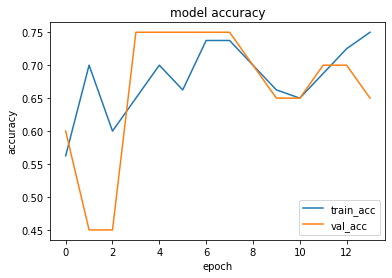

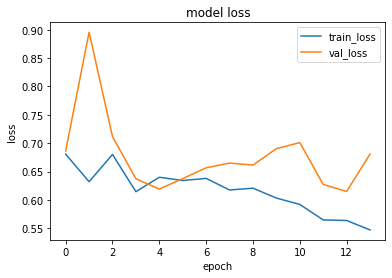

1it [00:00, 16644.06it/s]


prediction for video armflapping_1.mov is [[0.4954272]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.50060713]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.5176138]]


1it [00:00, 9341.43it/s]


prediction for video control_1.mov is [[0.48117024]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.47524384]]


1it [00:00, 6413.31it/s]


prediction for video control_3.mov is [[0.47270858]]
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6971 - accuracy: 0.5000 - precision_34: 0.5278 - recall_34: 0.4524 - val_loss: 0.6826 - val_accuracy: 0.6000 - val_precision_34: 0.5000 - val_recall_34: 0.6250
Epoch 2/75
3/3 [==============================] - 0s 182ms/step - loss: 0.6754 - accuracy: 0.6125 - precision_34: 0.5902 - recall_34: 0.8571 - val_loss: 0.7005 - val_accuracy: 0.5500 - val_precision_34: 0.4615 - val_recall_34: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6369 - accuracy: 0.7000 - precision_34: 0.6500 - recall_34: 0.9286 - val_loss: 0.6722 - val_accuracy: 0.6000 - val_precision_34: 0.5000 - val_recall_34: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6149 - accuracy: 0.7000 - precision_34: 0.6731 - recall_34: 0.8333 - val_loss: 0.6730 - val_accuracy: 0.7000 - val_precision_34: 0.6250 - val_recall_34: 0.6250
Epoch 5/75


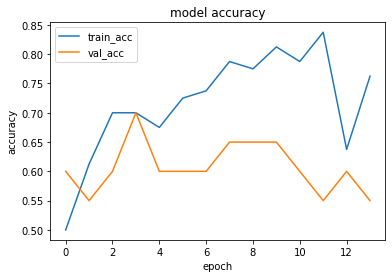

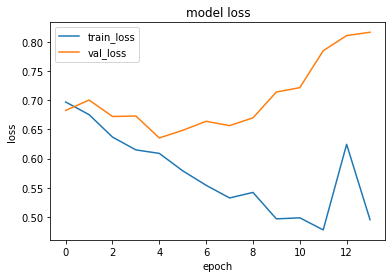

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.18640268]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.7721389]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.33568883]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.16210088]]


1it [00:00, 18641.35it/s]


prediction for video control_2.mov is [[0.15620509]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.15604526]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6870 - accuracy: 0.5000 - precision_35: 0.4000 - recall_35: 0.1622 - val_loss: 0.7122 - val_accuracy: 0.3500 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6701 - accuracy: 0.5375 - precision_35: 0.5000 - recall_35: 0.3243 - val_loss: 0.6575 - val_accuracy: 0.7000 - val_precision_35: 0.7059 - val_recall_35: 0.9231
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6332 - accuracy: 0.5875 - precision_35: 0.5312 - recall_35: 0.9189 - val_loss: 0.8675 - val_accuracy: 0.6500 - val_precision_35: 0.7143 - val_recall_35: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.8316 - accuracy: 0.5875 - precision_35: 0.5526 - recall_35: 0.5676 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_35: 0.6875 - val_recall_35: 0.8462
Epo

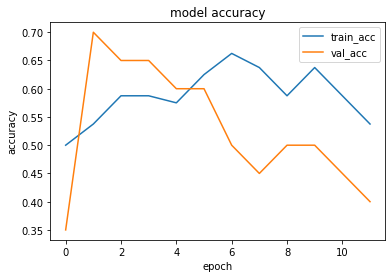

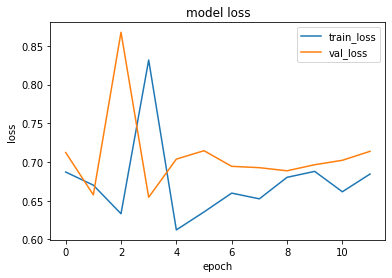

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.39942196]]


1it [00:00, 15768.06it/s]


prediction for video armflapping_3.mov is [[0.42443472]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.44008577]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.3806067]]


1it [00:00, 17331.83it/s]


prediction for video control_2.mov is [[0.37383008]]


1it [00:00, 21620.12it/s]


prediction for video control_3.mov is [[0.37105784]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6909 - accuracy: 0.4625 - precision_36: 0.4516 - recall_36: 0.3500 - val_loss: 0.6957 - val_accuracy: 0.5000 - val_precision_36: 0.5000 - val_recall_36: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 189ms/step - loss: 0.6712 - accuracy: 0.5625 - precision_36: 0.5342 - recall_36: 0.9750 - val_loss: 0.6877 - val_accuracy: 0.5000 - val_precision_36: 0.5000 - val_recall_36: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6495 - accuracy: 0.6250 - precision_36: 0.5962 - recall_36: 0.7750 - val_loss: 0.6809 - val_accuracy: 0.5000 - val_precision_36: 0.5000 - val_recall_36: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6287 - accuracy: 0.6125 - precision_36: 0.5789 - recall_36: 0.8250 - val_loss: 0.7174 - val_accuracy: 0.5000 - val_precision_36: 0.5000 - val_recall_36: 1.0000
Epoch 5/75


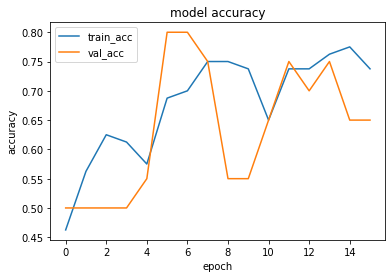

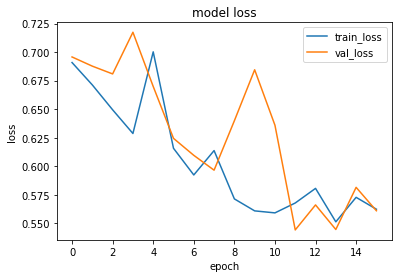

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.45104775]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.45898196]]


1it [00:00, 7037.42it/s]


prediction for video armflapping_2.mov is [[0.51216435]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.42033136]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.41086382]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.40089232]]
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6950 - accuracy: 0.4875 - precision_37: 0.4861 - recall_37: 0.8974 - val_loss: 0.6600 - val_accuracy: 0.7000 - val_precision_37: 0.6667 - val_recall_37: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6730 - accuracy: 0.5375 - precision_37: 0.5147 - recall_37: 0.8974 - val_loss: 0.6180 - val_accuracy: 0.7000 - val_precision_37: 0.7778 - val_recall_37: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6390 - accuracy: 0.6875 - precision_37: 0.6750 - recall_37: 0.6923 - val_loss: 0.6271 - val_accuracy: 0.6500 - val_precision_37: 0.8333 - val_recall_37: 0.4545
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6036 - accuracy: 0.7500 - precision_37: 0.7568 - recall_37: 0.7179 - val_loss: 0.6185 - val_accuracy: 0.6000 - val_precision_37: 0.7143 - val_recall_37: 0.4545
Epoch 5/75


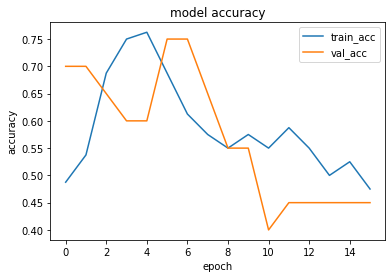

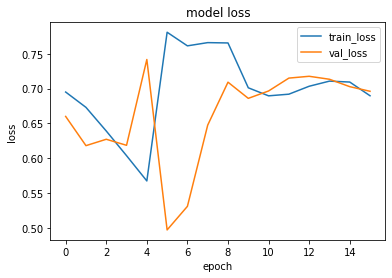

1it [00:00, 11125.47it/s]


prediction for video armflapping_1.mov is [[0.4617641]]


1it [00:00, 12865.96it/s]


prediction for video armflapping_3.mov is [[0.4847656]]


1it [00:00, 15477.14it/s]


prediction for video armflapping_2.mov is [[0.4628048]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.46218327]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.46287146]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.46346214]]


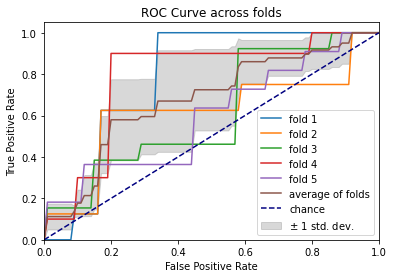

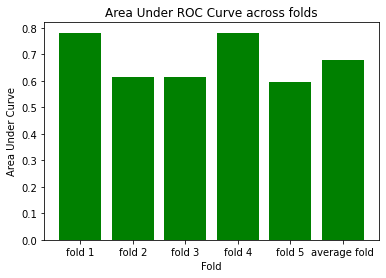

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6779 - accuracy: 0.5500 - precision_39: 0.5500 - recall_39: 0.7857 - val_loss: 0.6896 - val_accuracy: 0.4500 - val_precision_39: 0.4211 - val_recall_39: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6240 - accuracy: 0.6125 - precision_39: 0.5821 - recall_39: 0.9286 - val_loss: 0.8173 - val_accuracy: 0.4500 - val_precision_39: 0.4000 - val_recall_39: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 171ms/step - loss: 1.0432 - accuracy: 0.5125 - precision_39: 0.5714 - recall_39: 0.2857 - val_loss: 0.8562 - val_accuracy: 0.4000 - val_precision_39: 0.3750 - val_recall_39: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6681 - accuracy: 0.6125 - precision_39: 0.5821 - recall_39: 0.9286 - val_loss: 0.8053 - val_accuracy: 0.4500 - val_precision_39: 0.4211 - val_recall_39: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 180ms/step 

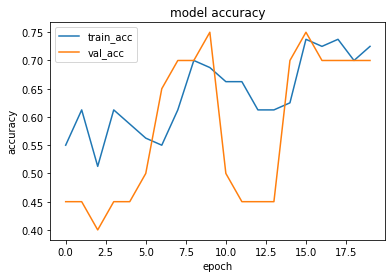

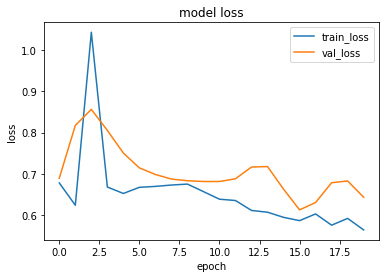

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.51470035]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.5080454]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.52104783]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.50156313]]


1it [00:00, 12228.29it/s]


prediction for video control_2.mov is [[0.49268758]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.49339384]]
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7011 - accuracy: 0.4000 - precision_40: 0.4423 - recall_40: 0.5476 - val_loss: 0.7088 - val_accuracy: 0.4500 - val_precision_40: 0.4211 - val_recall_40: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6850 - accuracy: 0.5000 - precision_40: 0.5135 - recall_40: 0.9048 - val_loss: 0.6802 - val_accuracy: 0.5000 - val_precision_40: 0.4444 - val_recall_40: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6665 - accuracy: 0.5875 - precision_40: 0.5634 - recall_40: 0.9524 - val_loss: 0.6427 - val_accuracy: 0.5500 - val_precision_40: 0.4667 - val_recall_40: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6448 - accuracy: 0.5750 - precision_40: 0.5571 - recall_40: 0.9286 - val_loss: 0.6373 - val_accuracy: 0.6000 - val_precision_40: 0.5000 - val_recall_40: 0.8750
Epoch 5/75


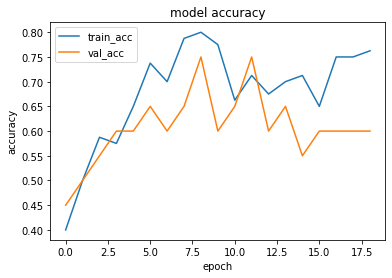

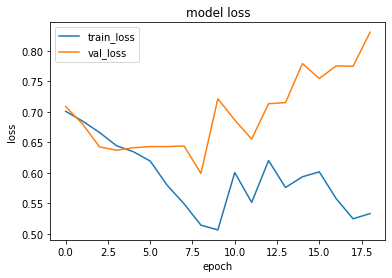

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.5052248]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.6448904]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.3549999]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.40621018]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.36656618]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.34913838]]
Epoch 1/75
3/3 [==============================] - 1s 152ms/step - loss: 0.6916 - accuracy: 0.4750 - precision_41: 0.4138 - recall_41: 0.3243 - val_loss: 0.7201 - val_accuracy: 0.3500 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6799 - accuracy: 0.6000 - precision_41: 1.0000 - recall_41: 0.1351 - val_loss: 0.6670 - val_accuracy: 0.6000 - val_precision_41: 1.0000 - val_recall_41: 0.3846
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6685 - accuracy: 0.6500 - precision_41: 0.6364 - recall_41: 0.5676 - val_loss: 0.6649 - val_accuracy: 0.6000 - val_precision_41: 1.0000 - val_recall_41: 0.3846
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6356 - accuracy: 0.6750 - precision_41: 0.8667 - recall_41: 0.3514 - val_loss: 0.6145 - val_accuracy: 0.8500 - val_precision_41: 1.0000 - val_recall_41: 0.7692
Epo

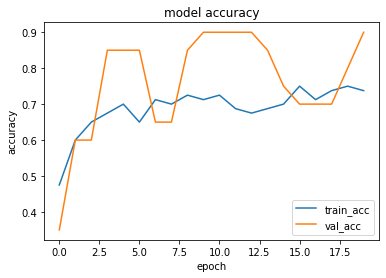

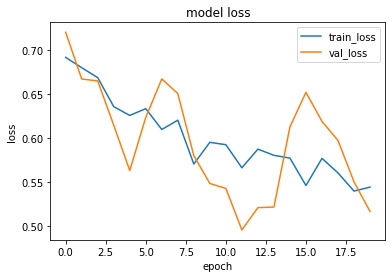

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5116378]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5590677]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5862529]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.45906353]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.43906146]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.4223204]]
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6995 - accuracy: 0.4625 - precision_42: 0.2000 - recall_42: 0.0250 - val_loss: 0.6883 - val_accuracy: 0.7000 - val_precision_42: 0.7500 - val_recall_42: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6744 - accuracy: 0.5625 - precision_42: 0.5490 - recall_42: 0.7000 - val_loss: 0.6697 - val_accuracy: 0.5500 - val_precision_42: 0.5263 - val_recall_42: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6537 - accuracy: 0.5875 - precision_42: 0.5538 - recall_42: 0.9000 - val_loss: 0.6585 - val_accuracy: 0.5500 - val_precision_42: 0.5263 - val_recall_42: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6220 - accuracy: 0.6125 - precision_42: 0.5714 - recall_42: 0.9000 - val_loss: 0.6479 - val_accuracy: 0.5500 - val_precision_42: 0.5263 - val_recall_42: 1.0000
Epoch 5/75
3

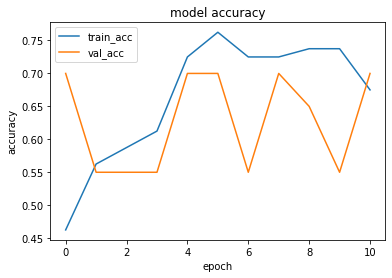

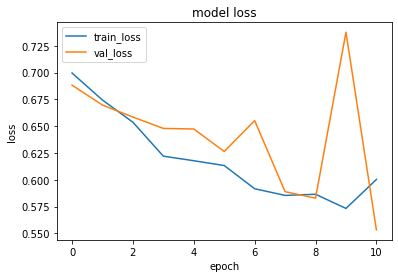

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.30977076]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.6156194]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.60687596]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.26711628]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.25212413]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.2797051]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7017 - accuracy: 0.5000 - precision_43: 0.4815 - recall_43: 0.3333 - val_loss: 0.6899 - val_accuracy: 0.5000 - val_precision_43: 1.0000 - val_recall_43: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6802 - accuracy: 0.6375 - precision_43: 0.6923 - recall_43: 0.4615 - val_loss: 0.6778 - val_accuracy: 0.5500 - val_precision_43: 0.6250 - val_recall_43: 0.4545
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6685 - accuracy: 0.6750 - precision_43: 0.6757 - recall_43: 0.6410 - val_loss: 0.6462 - val_accuracy: 0.7500 - val_precision_43: 1.0000 - val_recall_43: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6273 - accuracy: 0.6875 - precision_43: 0.7188 - recall_43: 0.5897 - val_loss: 0.6126 - val_accuracy: 0.6500 - val_precision_43: 0.6429 - val_recall_43: 0.8182
Epoch 5/75
3

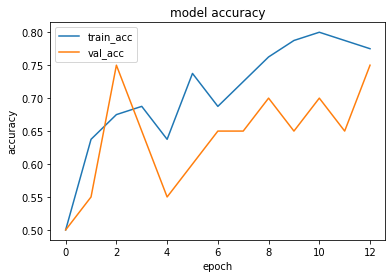

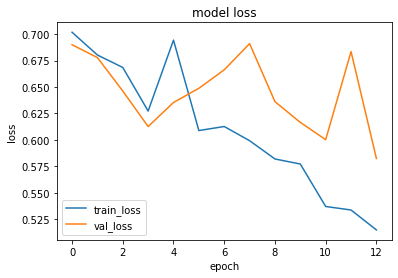

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.6049751]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.66431767]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.6534449]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.3455519]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.17107615]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.3522454]]


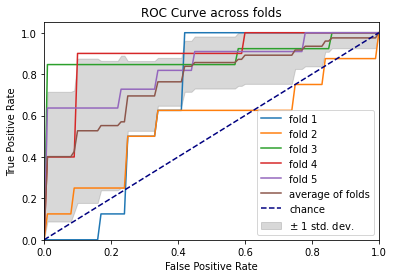

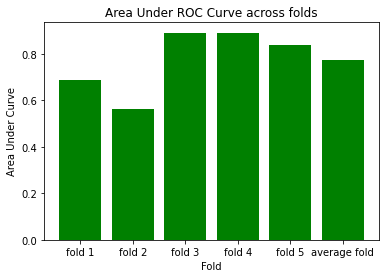

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.7026 - accuracy: 0.4000 - precision_45: 0.4483 - recall_45: 0.6190 - val_loss: 0.6987 - val_accuracy: 0.4500 - val_precision_45: 0.4211 - val_recall_45: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6670 - accuracy: 0.5875 - precision_45: 0.5600 - recall_45: 1.0000 - val_loss: 0.6828 - val_accuracy: 0.4500 - val_precision_45: 0.4211 - val_recall_45: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6314 - accuracy: 0.6000 - precision_45: 0.5781 - recall_45: 0.8810 - val_loss: 0.7492 - val_accuracy: 0.4500 - val_precision_45: 0.4211 - val_recall_45: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6110 - accuracy: 0.7000 - precision_45: 0.6731 - recall_45: 0.8333 - val_loss: 0.6628 - val_accuracy: 0.7000 - val_precision_45: 0.5833 - val_recall_45: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 143ms/step 

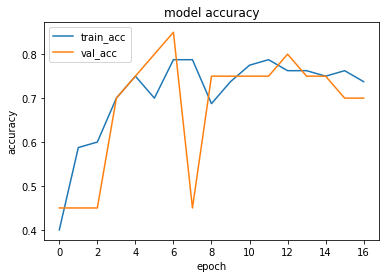

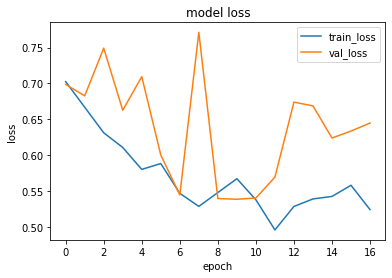

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5036262]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.52793974]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.55885905]]


1it [00:00, 13189.64it/s]


prediction for video control_1.mov is [[0.45047864]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.4215803]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.40634695]]
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6913 - accuracy: 0.4875 - precision_46: 0.5082 - recall_46: 0.7381 - val_loss: 0.6943 - val_accuracy: 0.5000 - val_precision_46: 0.4444 - val_recall_46: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6633 - accuracy: 0.6125 - precision_46: 0.5932 - recall_46: 0.8333 - val_loss: 0.6795 - val_accuracy: 0.5000 - val_precision_46: 0.4375 - val_recall_46: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6831 - accuracy: 0.5625 - precision_46: 0.6207 - recall_46: 0.4286 - val_loss: 0.6762 - val_accuracy: 0.6000 - val_precision_46: 0.5000 - val_recall_46: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 167ms/step - loss: 0.6365 - accuracy: 0.6625 - precision_46: 0.6230 - recall_46: 0.9048 - val_loss: 0.7084 - val_accuracy: 0.6000 - val_precision_46: 0.5000 - val_recall_46: 0.7500
Epoch 5/75


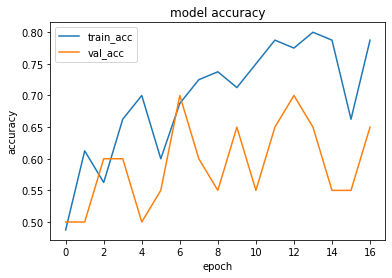

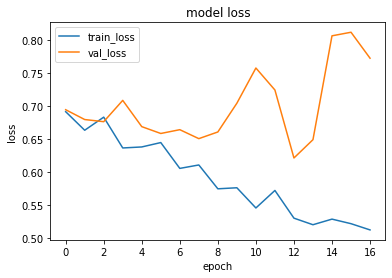

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.5934319]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.50697905]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.6456827]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.40949392]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.3363009]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.3393247]]
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6896 - accuracy: 0.4500 - precision_47: 0.1818 - recall_47: 0.0541 - val_loss: 0.6698 - val_accuracy: 0.8500 - val_precision_47: 1.0000 - val_recall_47: 0.7692
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6597 - accuracy: 0.6625 - precision_47: 0.6136 - recall_47: 0.7297 - val_loss: 0.5403 - val_accuracy: 0.6500 - val_precision_47: 0.6667 - val_recall_47: 0.9231
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6738 - accuracy: 0.5375 - precision_47: 0.5000 - recall_47: 0.9730 - val_loss: 0.6009 - val_accuracy: 0.9000 - val_precision_47: 1.0000 - val_recall_47: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6678 - accuracy: 0.6875 - precision_47: 0.6364 - recall_47: 0.7568 - val_loss: 0.6608 - val_accuracy: 0.6500 - val_precision_47: 1.0000 - val_recall_47: 0.4615
Epoch 5/75
3

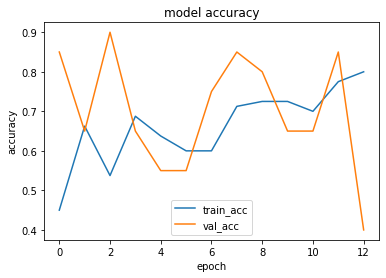

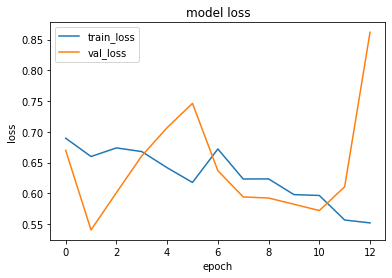

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.521777]]


1it [00:00, 20360.70it/s]


prediction for video armflapping_3.mov is [[0.50907123]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.5401782]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.5018454]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.4916327]]


1it [00:00, 11618.57it/s]


prediction for video control_3.mov is [[0.48845398]]
Epoch 1/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6925 - accuracy: 0.5875 - precision_48: 0.5636 - recall_48: 0.7750 - val_loss: 0.6930 - val_accuracy: 0.6000 - val_precision_48: 0.7500 - val_recall_48: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6700 - accuracy: 0.5375 - precision_48: 0.5556 - recall_48: 0.3750 - val_loss: 0.6723 - val_accuracy: 0.5000 - val_precision_48: 0.5000 - val_recall_48: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6518 - accuracy: 0.5875 - precision_48: 0.5522 - recall_48: 0.9250 - val_loss: 0.6544 - val_accuracy: 0.5000 - val_precision_48: 0.5000 - val_recall_48: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6295 - accuracy: 0.7125 - precision_48: 0.6809 - recall_48: 0.8000 - val_loss: 0.6525 - val_accuracy: 0.8000 - val_precision_48: 0.7500 - val_recall_48: 0.9000
Epoch 5/75


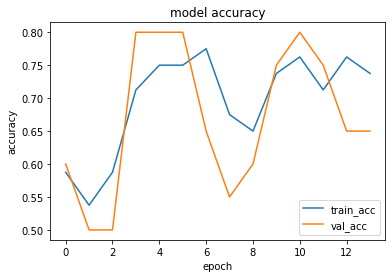

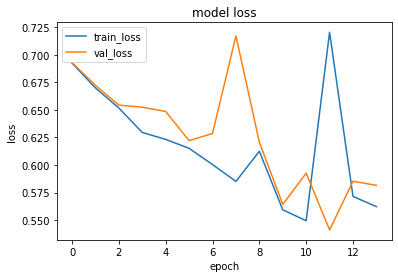

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.5456196]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6069399]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6639406]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.35166338]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.3031691]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.3347386]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6870 - accuracy: 0.6000 - precision_49: 0.5636 - recall_49: 0.7949 - val_loss: 0.6501 - val_accuracy: 0.6500 - val_precision_49: 0.7000 - val_recall_49: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6622 - accuracy: 0.6375 - precision_49: 0.6316 - recall_49: 0.6154 - val_loss: 0.6398 - val_accuracy: 0.6000 - val_precision_49: 1.0000 - val_recall_49: 0.2727
Epoch 3/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6266 - accuracy: 0.6125 - precision_49: 0.6818 - recall_49: 0.3846 - val_loss: 0.6232 - val_accuracy: 0.6500 - val_precision_49: 0.6111 - val_recall_49: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6819 - accuracy: 0.6250 - precision_49: 0.5692 - recall_49: 0.9487 - val_loss: 0.6138 - val_accuracy: 0.6500 - val_precision_49: 0.7000 - val_recall_49: 0.6364
Epoch 5/75
3

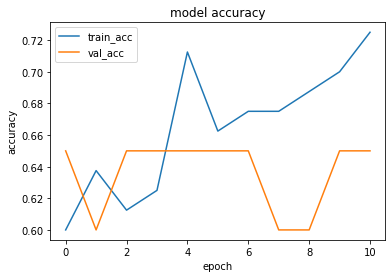

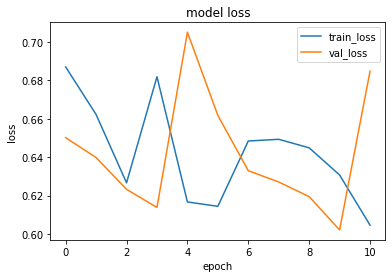

1it [00:00, 9597.95it/s]


prediction for video armflapping_1.mov is [[0.27745724]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.4215874]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.45683914]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.20732507]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.19963372]]


1it [00:00, 13357.66it/s]


prediction for video control_3.mov is [[0.21470097]]


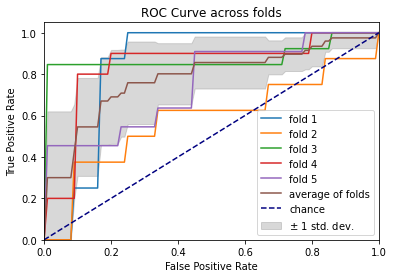

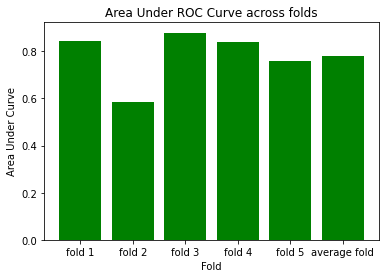

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6813 - accuracy: 0.5750 - precision_51: 0.5606 - recall_51: 0.8810 - val_loss: 0.6922 - val_accuracy: 0.4500 - val_precision_51: 0.4211 - val_recall_51: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6350 - accuracy: 0.6250 - precision_51: 0.5909 - recall_51: 0.9286 - val_loss: 0.8558 - val_accuracy: 0.4500 - val_precision_51: 0.4211 - val_recall_51: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6350 - accuracy: 0.6500 - precision_51: 0.6346 - recall_51: 0.7857 - val_loss: 0.6448 - val_accuracy: 0.7500 - val_precision_51: 0.6364 - val_recall_51: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6074 - accuracy: 0.7125 - precision_51: 0.7436 - recall_51: 0.6905 - val_loss: 0.6728 - val_accuracy: 0.7000 - val_precision_51: 0.5833 - val_recall_51: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 146ms/step 

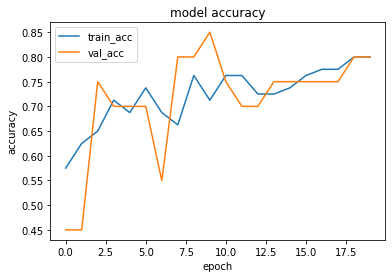

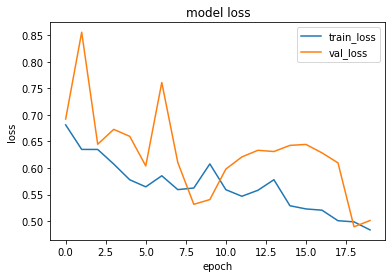

1it [00:00, 10782.27it/s]


prediction for video armflapping_1.mov is [[0.48690245]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.4957473]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.5426428]]


1it [00:00, 11781.75it/s]


prediction for video control_1.mov is [[0.42851514]]


1it [00:00, 10512.04it/s]


prediction for video control_2.mov is [[0.40304255]]


1it [00:00, 12826.62it/s]


prediction for video control_3.mov is [[0.3874819]]
Epoch 1/75
3/3 [==============================] - 0s 149ms/step - loss: 0.7067 - accuracy: 0.4000 - precision_52: 0.0000e+00 - recall_52: 0.0000e+00 - val_loss: 0.6799 - val_accuracy: 0.5500 - val_precision_52: 0.4000 - val_recall_52: 0.2500
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6819 - accuracy: 0.5125 - precision_52: 0.5273 - recall_52: 0.6905 - val_loss: 0.7163 - val_accuracy: 0.4500 - val_precision_52: 0.4211 - val_recall_52: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6732 - accuracy: 0.5625 - precision_52: 0.5455 - recall_52: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.5000 - val_precision_52: 0.4444 - val_recall_52: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6663 - accuracy: 0.6250 - precision_52: 0.5938 - recall_52: 0.9048 - val_loss: 0.6620 - val_accuracy: 0.5000 - val_precision_52: 0.4000 - val_recall_52: 0.5000
Epoc

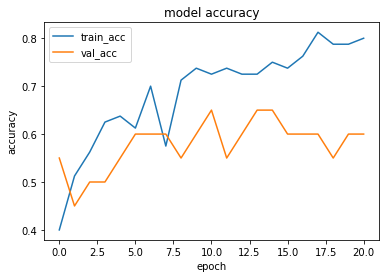

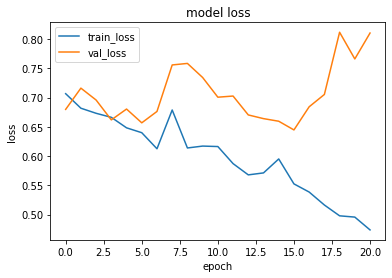

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.2931887]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.72268534]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.74003035]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.24023873]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.22546574]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.22419795]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6977 - accuracy: 0.4750 - precision_53: 0.3913 - recall_53: 0.2432 - val_loss: 0.7103 - val_accuracy: 0.3500 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6663 - accuracy: 0.5625 - precision_53: 1.0000 - recall_53: 0.0541 - val_loss: 0.7238 - val_accuracy: 0.3500 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6631 - accuracy: 0.5125 - precision_53: 0.4000 - recall_53: 0.1081 - val_loss: 0.6928 - val_accuracy: 0.7000 - val_precision_53: 0.7333 - val_recall_53: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6407 - accuracy: 0.6125 - precision_53: 0.5556 - recall_53: 0.8108 - val_loss: 0.6322 - val_accuracy: 0.7000 - val_precision_53: 0.7059 - val_recall_53: 0.

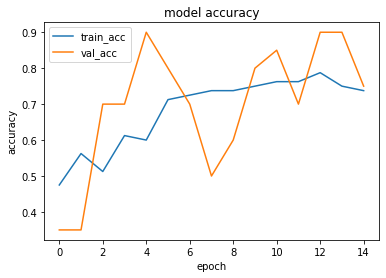

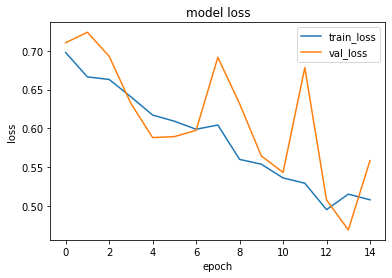

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.5292]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5592487]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.57683915]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.49977392]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.48822686]]


1it [00:00, 19691.57it/s]


prediction for video control_3.mov is [[0.48103988]]
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7000 - accuracy: 0.4250 - precision_54: 0.4375 - recall_54: 0.5250 - val_loss: 0.7076 - val_accuracy: 0.2500 - val_precision_54: 0.2222 - val_recall_54: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6790 - accuracy: 0.5000 - precision_54: 0.5000 - recall_54: 0.5250 - val_loss: 0.6882 - val_accuracy: 0.5500 - val_precision_54: 0.5263 - val_recall_54: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6632 - accuracy: 0.5875 - precision_54: 0.5507 - recall_54: 0.9500 - val_loss: 0.6717 - val_accuracy: 0.5500 - val_precision_54: 0.5263 - val_recall_54: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6177 - accuracy: 0.6250 - precision_54: 0.5781 - recall_54: 0.9250 - val_loss: 0.6177 - val_accuracy: 0.6000 - val_precision_54: 0.5556 - val_recall_54: 1.0000
Epoch 5/75


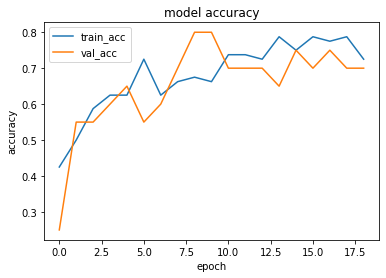

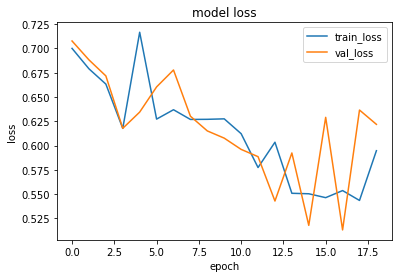

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.6626151]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.7256564]]


1it [00:00, 15252.01it/s]


prediction for video armflapping_2.mov is [[0.7732924]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.3821023]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.35380065]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.34498042]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.7109 - accuracy: 0.4875 - precision_55: 0.4865 - recall_55: 0.9231 - val_loss: 0.6989 - val_accuracy: 0.5500 - val_precision_55: 0.5500 - val_recall_55: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6958 - accuracy: 0.5875 - precision_55: 0.5517 - recall_55: 0.8205 - val_loss: 0.6807 - val_accuracy: 0.7000 - val_precision_55: 0.8571 - val_recall_55: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6768 - accuracy: 0.6625 - precision_55: 0.6364 - recall_55: 0.7179 - val_loss: 0.6347 - val_accuracy: 0.7500 - val_precision_55: 0.7143 - val_recall_55: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6620 - accuracy: 0.5375 - precision_55: 0.5156 - recall_55: 0.8462 - val_loss: 0.6084 - val_accuracy: 0.7000 - val_precision_55: 0.6667 - val_recall_55: 0.9091
Epoch 5/75


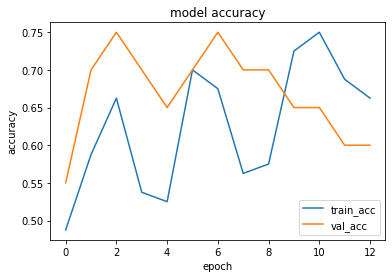

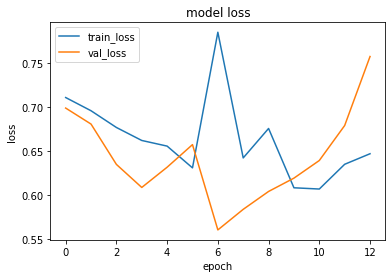

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.17582133]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.18405652]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.1786843]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.17522395]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.17520979]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.17526594]]


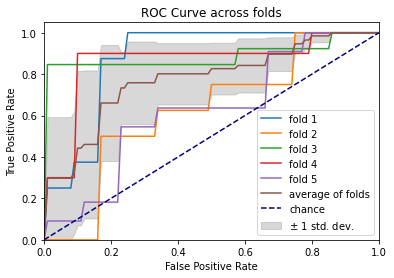

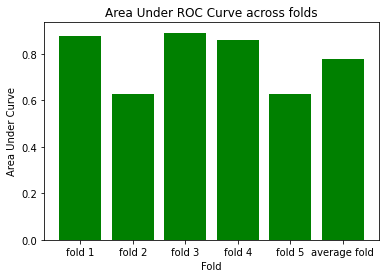

In [34]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6860 - accuracy: 0.6250 - precision_57: 0.6111 - recall_57: 0.7857 - val_loss: 0.6951 - val_accuracy: 0.5000 - val_precision_57: 0.4444 - val_recall_57: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6681 - accuracy: 0.5875 - precision_57: 0.5672 - recall_57: 0.9048 - val_loss: 0.6729 - val_accuracy: 0.6000 - val_precision_57: 0.5000 - val_recall_57: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6413 - accuracy: 0.7125 - precision_57: 0.7436 - recall_57: 0.6905 - val_loss: 0.7646 - val_accuracy: 0.4500 - val_precision_57: 0.4211 - val_recall_57: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6150 - accuracy: 0.5750 - precision_57: 0.5690 - recall_57: 0.7857 - val_loss: 0.6585 - val_accuracy: 0.7500 - val_precision_57: 0.6364 - val_recall_57: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 135ms/step 

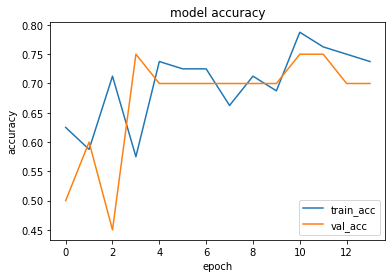

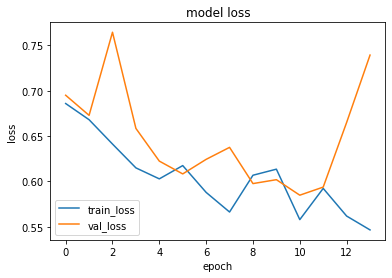

1it [00:00, 16578.28it/s]


prediction for video armflapping_1.mov is [[0.49354213]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_3.mov is [[0.5282488]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.5452699]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.46387276]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.45349866]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.43791205]]
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6917 - accuracy: 0.4875 - precision_58: 0.5143 - recall_58: 0.4286 - val_loss: 0.7114 - val_accuracy: 0.4000 - val_precision_58: 0.4000 - val_recall_58: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6885 - accuracy: 0.5375 - precision_58: 0.5316 - recall_58: 1.0000 - val_loss: 0.7251 - val_accuracy: 0.5000 - val_precision_58: 0.4286 - val_recall_58: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6520 - accuracy: 0.7125 - precision_58: 0.6667 - recall_58: 0.9048 - val_loss: 0.6431 - val_accuracy: 0.7000 - val_precision_58: 0.6667 - val_recall_58: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6408 - accuracy: 0.6250 - precision_58: 0.6304 - recall_58: 0.6905 - val_loss: 0.6496 - val_accuracy: 0.6000 - val_precision_58: 0.5000 - val_recall_58: 0.6250
Epoch 5/75


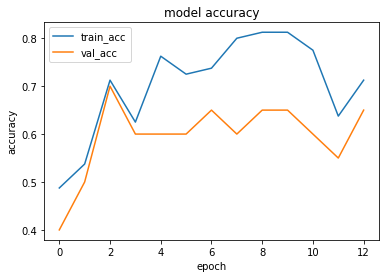

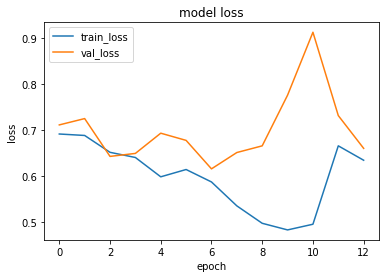

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.47307307]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.5271938]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.4865399]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.41624492]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.39035627]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.38503218]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6968 - accuracy: 0.5375 - precision_59: 0.5000 - recall_59: 0.4865 - val_loss: 0.7214 - val_accuracy: 0.3500 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6800 - accuracy: 0.5500 - precision_59: 0.6000 - recall_59: 0.0811 - val_loss: 0.7155 - val_accuracy: 0.3500 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6530 - accuracy: 0.6125 - precision_59: 0.6667 - recall_59: 0.3243 - val_loss: 0.7592 - val_accuracy: 0.6000 - val_precision_59: 0.6667 - val_recall_59: 0.7692
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6431 - accuracy: 0.6125 - precision_59: 0.5500 - recall_59: 0.8919 - val_loss: 0.6866 - val_accuracy: 0.6500 - val_precision_59: 0.6875 - val_recall_59: 0.

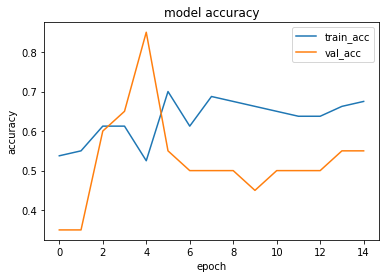

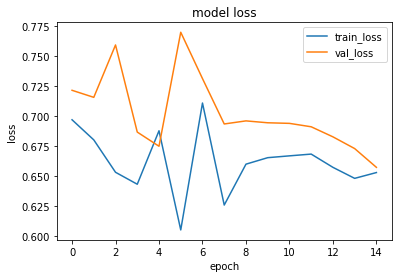

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.5245113]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.55572546]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.5575987]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.5038331]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.49586263]]


1it [00:00, 19508.39it/s]


prediction for video control_3.mov is [[0.4894055]]
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6928 - accuracy: 0.5125 - precision_60: 0.5116 - recall_60: 0.5500 - val_loss: 0.6924 - val_accuracy: 0.5000 - val_precision_60: 0.5000 - val_recall_60: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6725 - accuracy: 0.5000 - precision_60: 0.5000 - recall_60: 0.7000 - val_loss: 0.6859 - val_accuracy: 0.4500 - val_precision_60: 0.4706 - val_recall_60: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6461 - accuracy: 0.5875 - precision_60: 0.5574 - recall_60: 0.8500 - val_loss: 0.6616 - val_accuracy: 0.5500 - val_precision_60: 0.5263 - val_recall_60: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6455 - accuracy: 0.6000 - precision_60: 0.5606 - recall_60: 0.9250 - val_loss: 0.7348 - val_accuracy: 0.5000 - val_precision_60: 0.5000 - val_recall_60: 1.0000
Epoch 5/75
3

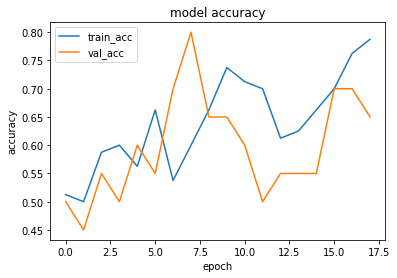

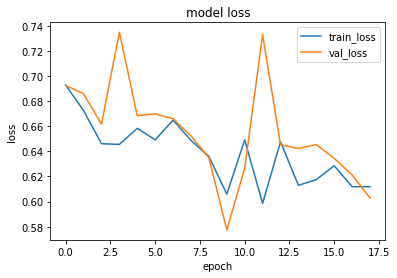

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.5317311]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.5524223]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.5860708]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.501584]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.48881614]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.48350403]]
Epoch 1/75
3/3 [==============================] - 1s 205ms/step - loss: 0.6891 - accuracy: 0.5125 - precision_61: 0.5000 - recall_61: 0.4872 - val_loss: 0.6460 - val_accuracy: 0.7000 - val_precision_61: 0.6923 - val_recall_61: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6593 - accuracy: 0.6000 - precision_61: 0.5660 - recall_61: 0.7692 - val_loss: 0.5898 - val_accuracy: 0.7000 - val_precision_61: 0.7273 - val_recall_61: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6210 - accuracy: 0.7125 - precision_61: 0.7000 - recall_61: 0.7179 - val_loss: 0.5754 - val_accuracy: 0.7000 - val_precision_61: 0.7273 - val_recall_61: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6624 - accuracy: 0.7000 - precision_61: 0.6316 - recall_61: 0.9231 - val_loss: 0.5805 - val_accuracy: 0.7000 - val_precision_61: 0.7778 - val_recall_61: 0.6364
Epoch 5/75


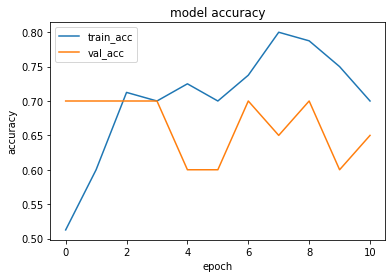

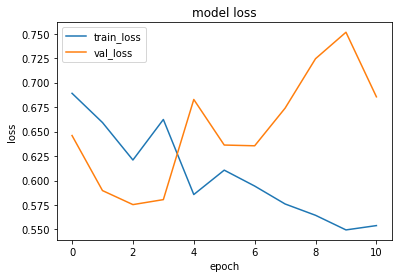

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.26280695]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.66692215]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.6750114]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.23844638]]


1it [00:00, 12192.74it/s]


prediction for video control_2.mov is [[0.2118496]]


1it [00:00, 18893.26it/s]

prediction for video control_3.mov is [[0.2085711]]


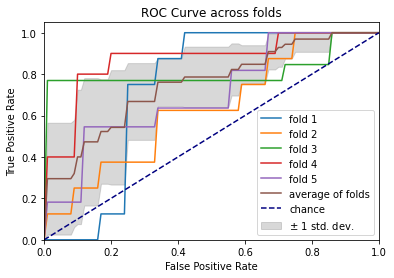

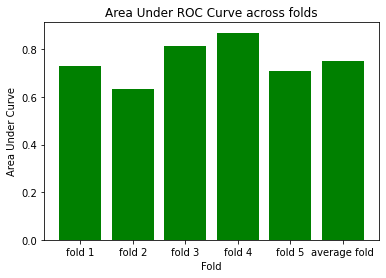

In [35]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6980 - accuracy: 0.5625 - precision_63: 0.5946 - recall_63: 0.5238 - val_loss: 0.6786 - val_accuracy: 0.6500 - val_precision_63: 0.5455 - val_recall_63: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6581 - accuracy: 0.7000 - precision_63: 0.7368 - recall_63: 0.6667 - val_loss: 0.6926 - val_accuracy: 0.4500 - val_precision_63: 0.4211 - val_recall_63: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6497 - accuracy: 0.5875 - precision_63: 0.5616 - recall_63: 0.9762 - val_loss: 0.7141 - val_accuracy: 0.4500 - val_precision_63: 0.4211 - val_recall_63: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6168 - accuracy: 0.6375 - precision_63: 0.5970 - recall_63: 0.9524 - val_loss: 0.6453 - val_accuracy: 0.7500 - val_precision_63: 0.6154 - val_recall_63: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 124ms/step 

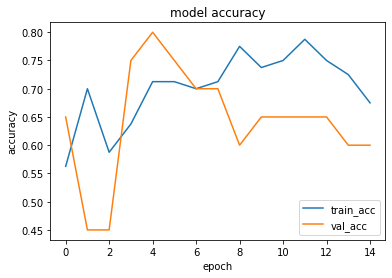

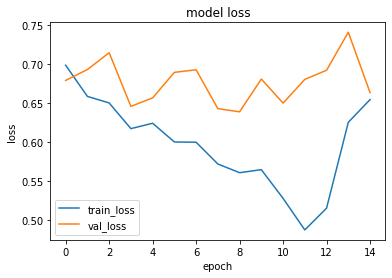

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5183239]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.54993224]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.54668605]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.496917]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.48780066]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.48398656]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6975 - accuracy: 0.4250 - precision_64: 0.4677 - recall_64: 0.6905 - val_loss: 0.7055 - val_accuracy: 0.4000 - val_precision_64: 0.4000 - val_recall_64: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6788 - accuracy: 0.6125 - precision_64: 0.5846 - recall_64: 0.9048 - val_loss: 0.6824 - val_accuracy: 0.5000 - val_precision_64: 0.4444 - val_recall_64: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6703 - accuracy: 0.6125 - precision_64: 0.6279 - recall_64: 0.6429 - val_loss: 0.6631 - val_accuracy: 0.5500 - val_precision_64: 0.4667 - val_recall_64: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6253 - accuracy: 0.6375 - precision_64: 0.5942 - recall_64: 0.9762 - val_loss: 0.8456 - val_accuracy: 0.6500 - val_precision_64: 0.6667 - val_recall_64: 0.2500
Epoch 5/75


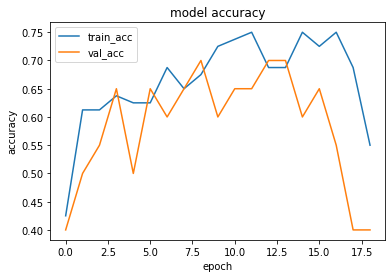

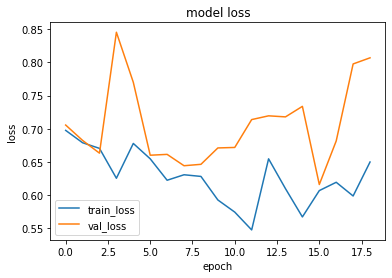

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.5582228]]


1it [00:00, 9686.61it/s]


prediction for video armflapping_3.mov is [[0.6003068]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.5628973]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.53094876]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.51537174]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.5128699]]
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6880 - accuracy: 0.5250 - precision_65: 0.4815 - recall_65: 0.3514 - val_loss: 0.7123 - val_accuracy: 0.3500 - val_precision_65: 0.0000e+00 - val_recall_65: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6689 - accuracy: 0.5500 - precision_65: 0.5152 - recall_65: 0.4595 - val_loss: 0.7005 - val_accuracy: 0.8500 - val_precision_65: 1.0000 - val_recall_65: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6665 - accuracy: 0.5500 - precision_65: 0.5161 - recall_65: 0.4324 - val_loss: 0.6278 - val_accuracy: 0.7000 - val_precision_65: 0.7333 - val_recall_65: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6442 - accuracy: 0.6000 - precision_65: 0.5424 - recall_65: 0.8649 - val_loss: 0.5981 - val_accuracy: 0.9000 - val_precision_65: 1.0000 - val_recall_65: 0.8462
Epoc

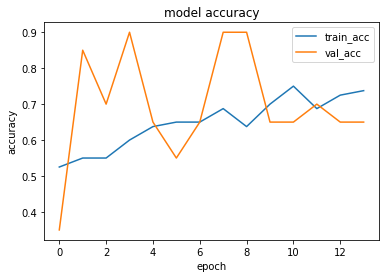

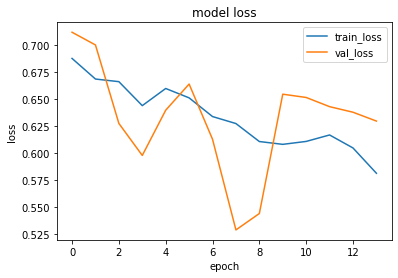

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.5095248]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_3.mov is [[0.5263773]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.5560648]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.48888636]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.48094708]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.47699517]]
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6797 - accuracy: 0.6000 - precision_66: 0.5667 - recall_66: 0.8500 - val_loss: 0.6617 - val_accuracy: 0.6000 - val_precision_66: 0.5625 - val_recall_66: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6421 - accuracy: 0.7125 - precision_66: 0.6809 - recall_66: 0.8000 - val_loss: 0.7569 - val_accuracy: 0.5000 - val_precision_66: 0.5000 - val_recall_66: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6464 - accuracy: 0.6250 - precision_66: 0.5714 - recall_66: 1.0000 - val_loss: 0.6398 - val_accuracy: 0.6000 - val_precision_66: 0.5625 - val_recall_66: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6421 - accuracy: 0.6750 - precision_66: 0.6944 - recall_66: 0.6250 - val_loss: 0.6324 - val_accuracy: 0.7000 - val_precision_66: 0.7000 - val_recall_66: 0.7000
Epoch 5/75


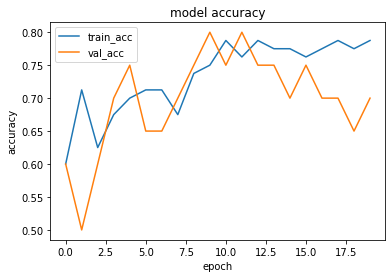

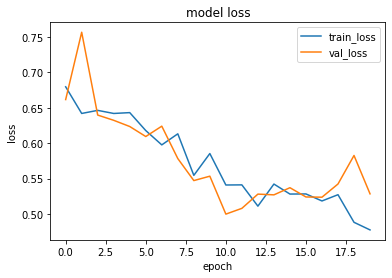

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.303527]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.6034633]]


1it [00:00, 10538.45it/s]


prediction for video armflapping_2.mov is [[0.686429]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.5949385]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.4100455]]


1it [00:00, 20971.52it/s]


prediction for video control_3.mov is [[0.586216]]
Epoch 1/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6870 - accuracy: 0.5750 - precision_67: 0.5532 - recall_67: 0.6667 - val_loss: 0.6561 - val_accuracy: 0.6000 - val_precision_67: 0.8000 - val_recall_67: 0.3636
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6760 - accuracy: 0.6000 - precision_67: 0.7059 - recall_67: 0.3077 - val_loss: 0.6043 - val_accuracy: 0.6500 - val_precision_67: 0.7000 - val_recall_67: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6493 - accuracy: 0.6875 - precision_67: 0.6400 - recall_67: 0.8205 - val_loss: 0.5819 - val_accuracy: 0.7000 - val_precision_67: 0.7273 - val_recall_67: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6175 - accuracy: 0.7125 - precision_67: 0.6600 - recall_67: 0.8462 - val_loss: 0.5659 - val_accuracy: 0.7000 - val_precision_67: 0.7273 - val_recall_67: 0.7273
Epoch 5/75
3/

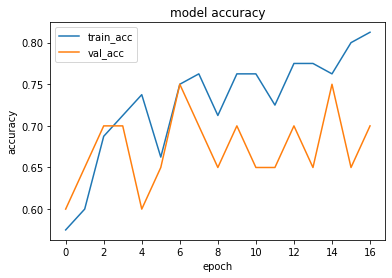

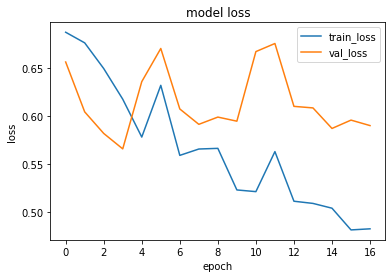

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.44341868]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.6659853]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.6864706]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.296529]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.2744636]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26491773]]


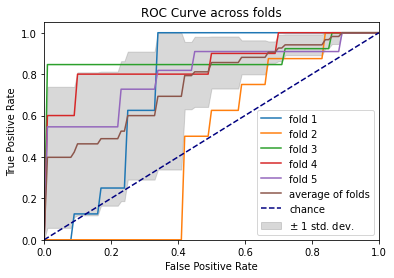

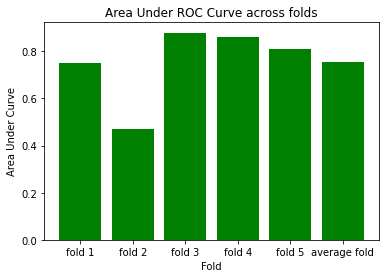

In [36]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 151ms/step - loss: 0.7013 - accuracy: 0.5250 - precision_69: 0.5556 - recall_69: 0.4762 - val_loss: 0.7074 - val_accuracy: 0.4000 - val_precision_69: 0.4000 - val_recall_69: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6964 - accuracy: 0.4875 - precision_69: 0.5067 - recall_69: 0.9048 - val_loss: 0.7007 - val_accuracy: 0.4500 - val_precision_69: 0.4211 - val_recall_69: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6658 - accuracy: 0.6000 - precision_69: 0.5833 - recall_69: 0.8333 - val_loss: 0.6666 - val_accuracy: 0.8000 - val_precision_69: 0.6667 - val_recall_69: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6371 - accuracy: 0.6375 - precision_69: 0.6275 - recall_69: 0.7619 - val_loss: 0.6633 - val_accuracy: 0.6000 - val_precision_69: 0.5000 - val_recall_69: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 132ms/step 

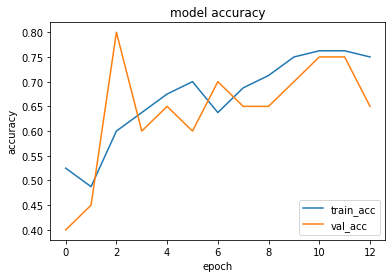

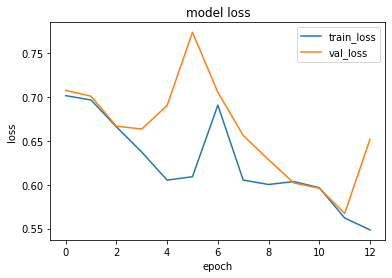

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.50157034]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.49389702]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.49714422]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.49359837]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.48862332]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.48743632]]
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6930 - accuracy: 0.4750 - precision_70: 0.5000 - recall_70: 0.5952 - val_loss: 0.7101 - val_accuracy: 0.4000 - val_precision_70: 0.4000 - val_recall_70: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 197ms/step - loss: 0.6795 - accuracy: 0.5500 - precision_70: 0.5484 - recall_70: 0.8095 - val_loss: 0.6697 - val_accuracy: 0.6500 - val_precision_70: 0.5714 - val_recall_70: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6431 - accuracy: 0.6625 - precision_70: 0.6154 - recall_70: 0.9524 - val_loss: 0.6751 - val_accuracy: 0.5500 - val_precision_70: 0.4667 - val_recall_70: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 179ms/step - loss: 0.6404 - accuracy: 0.6000 - precision_70: 0.5735 - recall_70: 0.9286 - val_loss: 0.7255 - val_accuracy: 0.6000 - val_precision_70: 0.5000 - val_recall_70: 0.3750
Epoch 5/75


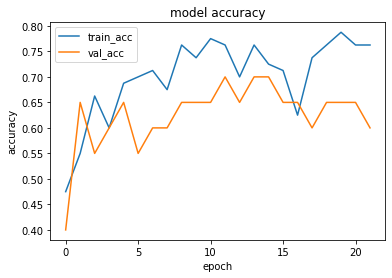

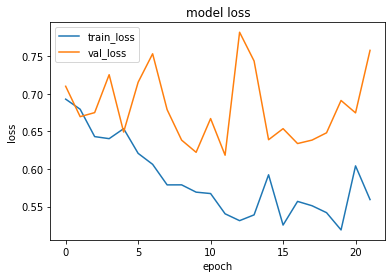

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.43151587]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.5679612]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5838738]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.32013667]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.29263845]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.28091022]]
Epoch 1/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6940 - accuracy: 0.5625 - precision_71: 0.5156 - recall_71: 0.8919 - val_loss: 0.6925 - val_accuracy: 0.4000 - val_precision_71: 1.0000 - val_recall_71: 0.0769
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6610 - accuracy: 0.5625 - precision_71: 1.0000 - recall_71: 0.0541 - val_loss: 0.7274 - val_accuracy: 0.4000 - val_precision_71: 1.0000 - val_recall_71: 0.0769
Epoch 3/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6519 - accuracy: 0.5875 - precision_71: 0.7000 - recall_71: 0.1892 - val_loss: 0.6528 - val_accuracy: 0.9000 - val_precision_71: 1.0000 - val_recall_71: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6386 - accuracy: 0.5750 - precision_71: 0.5273 - recall_71: 0.7838 - val_loss: 0.5898 - val_accuracy: 0.6500 - val_precision_71: 0.6667 - val_recall_71: 0.9231
Epoch 5/75


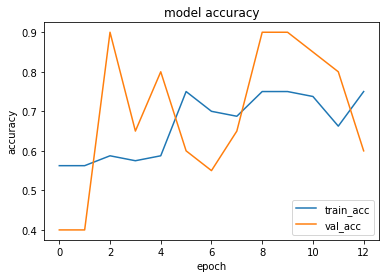

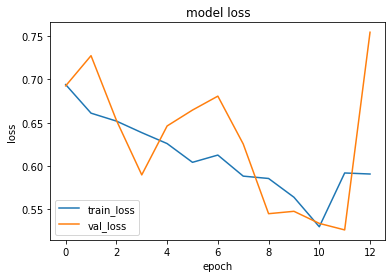

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.49585006]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5082624]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.50339746]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.4881412]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.48552328]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.4823399]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7015 - accuracy: 0.4500 - precision_72: 0.4333 - recall_72: 0.3250 - val_loss: 0.6859 - val_accuracy: 0.6000 - val_precision_72: 0.5714 - val_recall_72: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6792 - accuracy: 0.6125 - precision_72: 0.5738 - recall_72: 0.8750 - val_loss: 0.6834 - val_accuracy: 0.5000 - val_precision_72: 0.5000 - val_recall_72: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6305 - accuracy: 0.6125 - precision_72: 0.5714 - recall_72: 0.9000 - val_loss: 0.6554 - val_accuracy: 0.6500 - val_precision_72: 0.5882 - val_recall_72: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6339 - accuracy: 0.6375 - precision_72: 0.6000 - recall_72: 0.8250 - val_loss: 0.6599 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 1.0000
Epoch 5/75
3

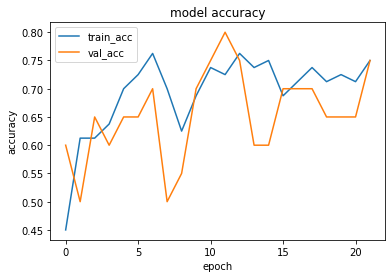

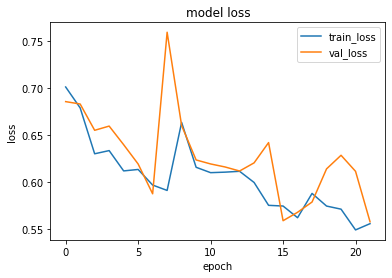

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4827137]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_3.mov is [[0.6023637]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.67944044]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.32794273]]


1it [00:00, 10645.44it/s]


prediction for video control_2.mov is [[0.2958861]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.30108404]]
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6813 - accuracy: 0.5375 - precision_73: 0.5179 - recall_73: 0.7436 - val_loss: 0.6544 - val_accuracy: 0.6000 - val_precision_73: 0.6154 - val_recall_73: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6739 - accuracy: 0.6375 - precision_73: 0.6087 - recall_73: 0.7179 - val_loss: 0.6218 - val_accuracy: 0.6500 - val_precision_73: 0.7500 - val_recall_73: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 180ms/step - loss: 0.6230 - accuracy: 0.7000 - precision_73: 0.6744 - recall_73: 0.7436 - val_loss: 0.6060 - val_accuracy: 0.6500 - val_precision_73: 0.6250 - val_recall_73: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 181ms/step - loss: 0.6561 - accuracy: 0.6500 - precision_73: 0.6038 - recall_73: 0.8205 - val_loss: 0.6127 - val_accuracy: 0.7000 - val_precision_73: 0.7778 - val_recall_73: 0.6364
Epoch 5/75


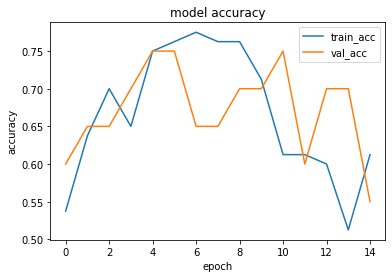

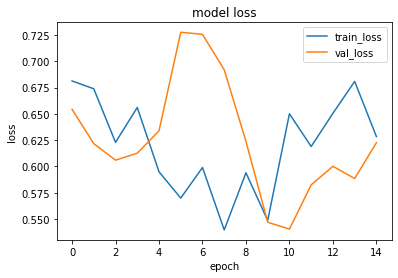

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.44812843]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.46550217]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.46442223]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.43986222]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.4367498]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.43620595]]


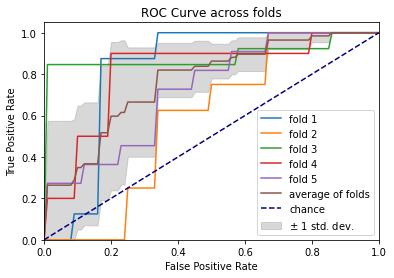

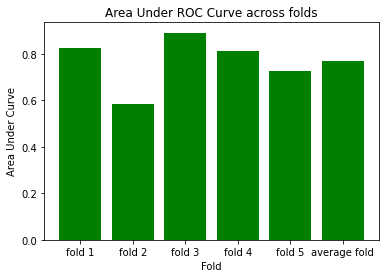

In [37]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])

Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.7024 - accuracy: 0.4625 - precision_75: 0.4925 - recall_75: 0.7857 - val_loss: 0.6967 - val_accuracy: 0.4500 - val_precision_75: 0.4211 - val_recall_75: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6722 - accuracy: 0.5750 - precision_75: 0.5541 - recall_75: 0.9762 - val_loss: 0.6685 - val_accuracy: 0.5500 - val_precision_75: 0.4706 - val_recall_75: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6598 - accuracy: 0.6375 - precision_75: 0.6066 - recall_75: 0.8810 - val_loss: 0.6712 - val_accuracy: 0.5000 - val_precision_75: 0.4444 - val_recall_75: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 117ms/step - loss: 0.6458 - accuracy: 0.6000 - precision_75: 0.5714 - recall_75: 0.9524 - val_loss: 0.7115 - val_accuracy: 0.4500 - val_precision_75: 0.4211 - val_recall_75: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 118ms/step 

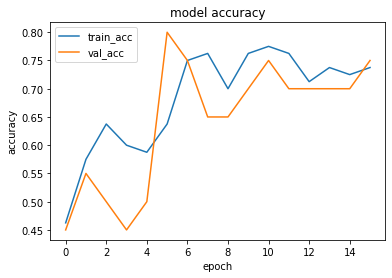

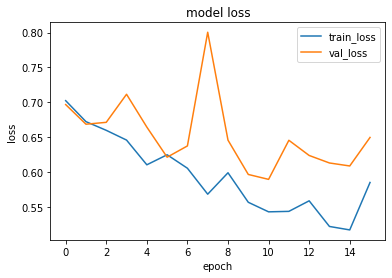

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.50190747]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5101462]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.5197933]]


1it [00:00, 12671.61it/s]


prediction for video control_1.mov is [[0.4838854]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.47437018]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.471933]]
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6736 - accuracy: 0.5500 - precision_76: 0.5625 - recall_76: 0.6429 - val_loss: 0.7250 - val_accuracy: 0.4500 - val_precision_76: 0.4211 - val_recall_76: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6619 - accuracy: 0.5875 - precision_76: 0.5616 - recall_76: 0.9762 - val_loss: 0.6122 - val_accuracy: 0.7500 - val_precision_76: 0.8000 - val_recall_76: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6743 - accuracy: 0.5875 - precision_76: 0.7368 - recall_76: 0.3333 - val_loss: 0.6149 - val_accuracy: 0.6000 - val_precision_76: 0.5000 - val_recall_76: 0.1250
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6619 - accuracy: 0.6000 - precision_76: 0.7778 - recall_76: 0.3333 - val_loss: 0.6425 - val_accuracy: 0.7000 - val_precision_76: 0.6250 - val_recall_76: 0.6250
Epoch 5/75
3/

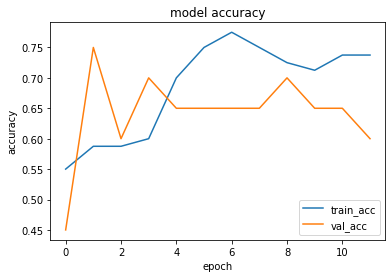

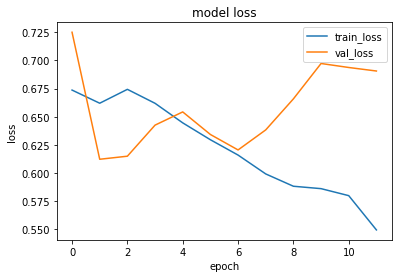

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.60090137]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.6494591]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6641398]]


1it [00:00, 3344.74it/s]


prediction for video control_1.mov is [[0.5250764]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.4932282]]


1it [00:00, 12192.74it/s]


prediction for video control_3.mov is [[0.44488937]]
Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6821 - accuracy: 0.6000 - precision_77: 0.5532 - recall_77: 0.7027 - val_loss: 0.6976 - val_accuracy: 0.4500 - val_precision_77: 1.0000 - val_recall_77: 0.1538
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6568 - accuracy: 0.5750 - precision_77: 0.5556 - recall_77: 0.4054 - val_loss: 0.6739 - val_accuracy: 0.7000 - val_precision_77: 0.7333 - val_recall_77: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6401 - accuracy: 0.5625 - precision_77: 0.5167 - recall_77: 0.8378 - val_loss: 0.6452 - val_accuracy: 0.9000 - val_precision_77: 1.0000 - val_recall_77: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6170 - accuracy: 0.7375 - precision_77: 0.7000 - recall_77: 0.7568 - val_loss: 0.6955 - val_accuracy: 0.7000 - val_precision_77: 1.0000 - val_recall_77: 0.5385
Epoch 5/75


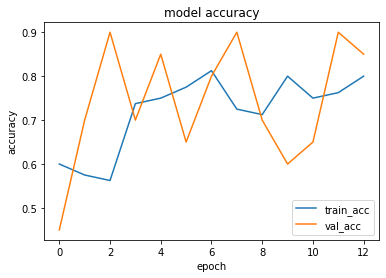

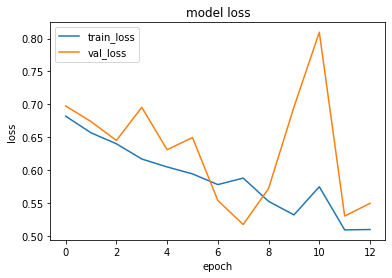

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.51372504]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.5261369]]


1it [00:00, 8630.26it/s]


prediction for video armflapping_2.mov is [[0.535855]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.5010607]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.49554104]]


1it [00:00, 13025.79it/s]


prediction for video control_3.mov is [[0.49427003]]
Epoch 1/75
3/3 [==============================] - 1s 154ms/step - loss: 0.6927 - accuracy: 0.5125 - precision_78: 0.5082 - recall_78: 0.7750 - val_loss: 0.6949 - val_accuracy: 0.5500 - val_precision_78: 0.6667 - val_recall_78: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6682 - accuracy: 0.5625 - precision_78: 0.6471 - recall_78: 0.2750 - val_loss: 0.6729 - val_accuracy: 0.5500 - val_precision_78: 0.5263 - val_recall_78: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6136 - accuracy: 0.6375 - precision_78: 0.5846 - recall_78: 0.9500 - val_loss: 0.6493 - val_accuracy: 0.5500 - val_precision_78: 0.5263 - val_recall_78: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6567 - accuracy: 0.6375 - precision_78: 0.5965 - recall_78: 0.8500 - val_loss: 0.6383 - val_accuracy: 0.5500 - val_precision_78: 0.5294 - val_recall_78: 0.9000
Epoch 5/75


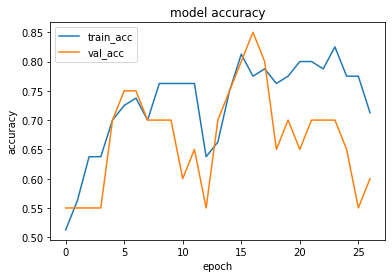

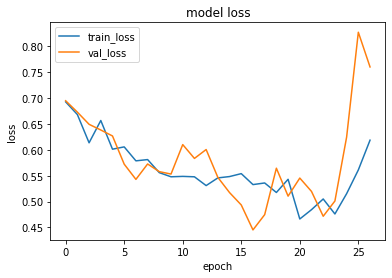

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.4625147]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.7595338]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_2.mov is [[0.5558899]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.14461365]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.47157604]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.13562009]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6932 - accuracy: 0.5250 - precision_79: 0.5088 - recall_79: 0.7436 - val_loss: 0.6702 - val_accuracy: 0.5500 - val_precision_79: 0.7500 - val_recall_79: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6751 - accuracy: 0.6250 - precision_79: 0.6957 - recall_79: 0.4103 - val_loss: 0.6391 - val_accuracy: 0.6500 - val_precision_79: 0.6667 - val_recall_79: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 115ms/step - loss: 0.6457 - accuracy: 0.6875 - precision_79: 0.6667 - recall_79: 0.7179 - val_loss: 0.5993 - val_accuracy: 0.6500 - val_precision_79: 0.6667 - val_recall_79: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 113ms/step - loss: 0.6764 - accuracy: 0.5875 - precision_79: 0.5429 - recall_79: 0.9744 - val_loss: 0.5954 - val_accuracy: 0.7000 - val_precision_79: 0.6667 - val_recall_79: 0.9091
Epoch 5/75


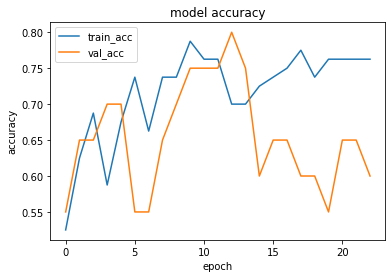

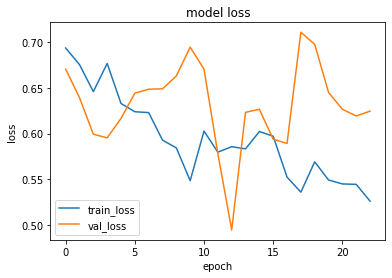

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.3774823]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5830593]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.7274151]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.31241202]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.2895695]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.2845443]]


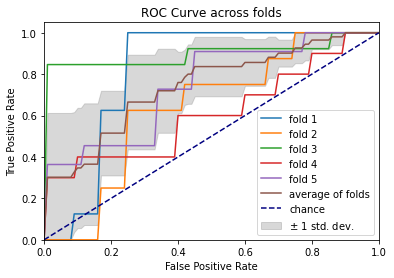

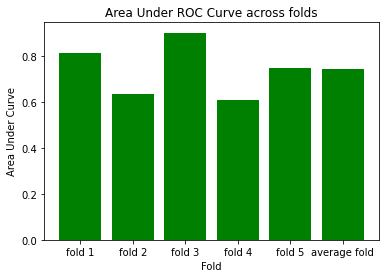

In [38]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[early_stopping, checkpoint])